In [9]:
#### percentage figures
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from utils.generator_utils import random_pd_matrix_generator
from utils.function_utils import (
    calculate_P,
    FW_faster,
    Parameters,
)
from utils.function_utils import *
from utils.sdp_solution import sdp_solver,  sdp_solver_worst_case
import pymanopt
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

np.random.seed(0)
d = 2
n = d # State~x dimension
m = d  # Controller~u dimension
p = d  # Measurement~y dimension

c = 0.1
T_max = 2
amb_set = "KL"
tol = 1e-8


rhos = np.linspace(0, 10, 10)
replications = 10
obj_val_worst_case_policy_worst_case_dist = np.zeros((rhos.shape[0], replications))
obj_val_nominal_policy_worst_case_dist = np.zeros((rhos.shape[0], replications))
obj_val_worst_case_policy_random_dist = np.zeros((rhos.shape[0], replications))
obj_val_worst_case_policy_nominal_dist = np.zeros((rhos.shape[0], replications))
obj_val_nominal_policy_nominal_worst_dist = np.zeros((rhos.shape[0], replications))
obj_val_nominal_policy_nominal_dist = np.zeros((rhos.shape[0], replications))



for rep in range(replications):
    X0_hat = random_pd_matrix_generator(n)
    # Nominal covariance matrix of the initial state
    # Generate system dynamics
    A_big = np.zeros((n, n, T_max))
    B_big = np.zeros((n, m, T_max))
    C_big = np.zeros((p, n, T_max))
    # Generate V and R (both PD)
    R_big = np.zeros((m, m, T_max))
    V_hat_big = np.zeros((p, p, T_max))
    Q_big = np.zeros((n, n, T_max + 1))
    W_hat_big = np.zeros((n, n, T_max))

    sdp_solver_time = []
    fw_solver_time = []
    for i in range(T_max):
        temp = np.ones((n, n))
        A_big[:, :, i] = (np.eye(n) + np.triu(temp, 1) - np.triu(temp, 2)) * 0.1
        B_big[:, :, i] = random_pd_matrix_generator(n)
        C_big[:, :, i] = np.eye(n)
        Q_big[:, :, i] = np.eye(n)
        W_hat_big[:, :, i] = random_pd_matrix_generator(n)
        R_big[:, :, i] = np.eye(m)
    # rand_nxn = np.random.rand((n, n))
    Q_big[:, :, T_max] = random_pd_matrix_generator(n) # rand_nxn @ rand_nxn.T

    for i in range(T_max):
        V_hat_big[:, :, i] = random_pd_matrix_generator(p)


    #######################################################################
    T = T_max
    # print("\nReplication:" + str(rep))
    A = A_big[:, :, :T]
    B = B_big[:, :, :T]
    C = C_big[:, :, :T]
    Q = Q_big[:, :, : T + 1]
    R = R_big[:, :, :T]
    W_hat = W_hat_big[:, :, :T]
    V_hat = V_hat_big[:, :, :T]

    W_hat_arranged = np.zeros([n * (T+1) , n * (T+1)])
    V_hat_arranged = np.zeros([p * T, p * T])
    W_hat_arranged[0:n, 0:n] = X0_hat
    for t in range(T_max):
        W_hat_arranged[n*(t+1) : n*(t+1)+ n, n*(t+1): n*(t+1) + n] = W_hat[:, :, t]
    for t in range(T_max):
        V_hat_arranged[p*t : p*t + p, p*t : p*t + p] = V_hat[:, :, t]
    for r, rho in enumerate(rhos):
        print("Radius:{}".format(rho))
        params_numpy = Parameters(
            A=A,
            B=B,
            C=C,
            Q=Q,
            R=R,
            T=T,
            P=np.zeros(n),
            X0_hat=X0_hat,
            V_hat=V_hat,
            W_hat=W_hat,
            rho=rho,
            amb_set=amb_set,
            tol=tol,
            tensors=False,
        )
        obj_val_sdp, U_opt, W_opt_sdp, V_opt_sdp = sdp_solver(params_numpy, output_vars=1)
        obj_val_sdp = obj_val_fixed(params=params_numpy, 
                                            U_opt=U_opt, 
                                            W_var=W_opt_sdp,
                                            V_var=V_opt_sdp)
        if rho == 0:
            U_nominal = U_opt
            obj_val_sdp = obj_val_fixed(params=params_numpy, 
                                            U_opt=U_opt, 
                                            W_var=W_hat_arranged,
                                            V_var=V_hat_arranged)
            nom_pol_nom_dist = obj_val_sdp
            W_nominal_ = W_hat_arranged
            V_nominal_ = V_hat_arranged
            W_nominal_worst = W_hat_arranged
            V_nominal_worst = V_hat_arranged
            obj_nominal_case = nom_pol_nom_dist
        else:
            W_nominal_worst, V_nominal_worst, obj_nominal_case = sdp_solver_worst_case(params_numpy, U_nominal, obj_return_on=1)
            obj_nominal_case = obj_val_fixed(params=params_numpy, 
                                                    U_opt=U_nominal, 
                                                    W_var=W_nominal_worst,
                                                    V_var=V_nominal_worst)
        obj_val_nominal_policy_worst_case_dist[r, rep] = obj_val_fixed(params=params_numpy, 
                                            U_opt=U_nominal, 
                                            W_var=W_opt_sdp,
                                            V_var=V_opt_sdp)
        obj_val_worst_case_policy_nominal_dist[r, rep] = obj_val_fixed(params=params_numpy, 
                                                    U_opt=U_opt, 
                                                    W_var=W_nominal_,
                                                    V_var=V_nominal_)
        obj_val_nominal_policy_nominal_worst_dist[r, rep] = obj_nominal_case
        obj_val_worst_case_policy_worst_case_dist[r, rep] = obj_val_sdp
        obj_val_nominal_policy_nominal_dist[r, rep] = nom_pol_nom_dist


Radius:0.0
                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Aug 06 05:23:16 PM: Your problem has 116 variables, 181 constraints, and 0 parameters.
(CVXPY) Aug 06 05:23:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 05:23:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 05:23:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 06 05:23:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 06 05:23:16 PM: Compiling problem (target solv

/Users/taskesen/Documents/research/dr-control/code/env/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/taskesen/Documents/research/dr-control/code/env/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/taskesen/Documents/research/dr-control/code/env/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


(CVXPY) Aug 06 05:23:16 PM: Finished problem compilation (took 4.865e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Aug 06 05:23:16 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Aug 06 05:23:16 PM: Problem
(CVXPY) Aug 06 05:23:16 PM:   Name                   :                 
(CVXPY) Aug 06 05:23:16 PM:   Objective sense        : maximize        
(CVXPY) Aug 06 05:23:16 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Aug 06 05:23:16 PM:   Constraints            : 130             
(CVXPY) Aug 06 05:23:16 PM:   Affine conic cons.     : 0               
(CVXPY) Aug 06 05:23:16 PM:   Disjunctive cons.      : 0               
(CVXPY) Aug 06 05:23:16 PM:   Cones                  : 10              
(CVXPY) Aug 06 05:23:16 PM:   Scalar variabl

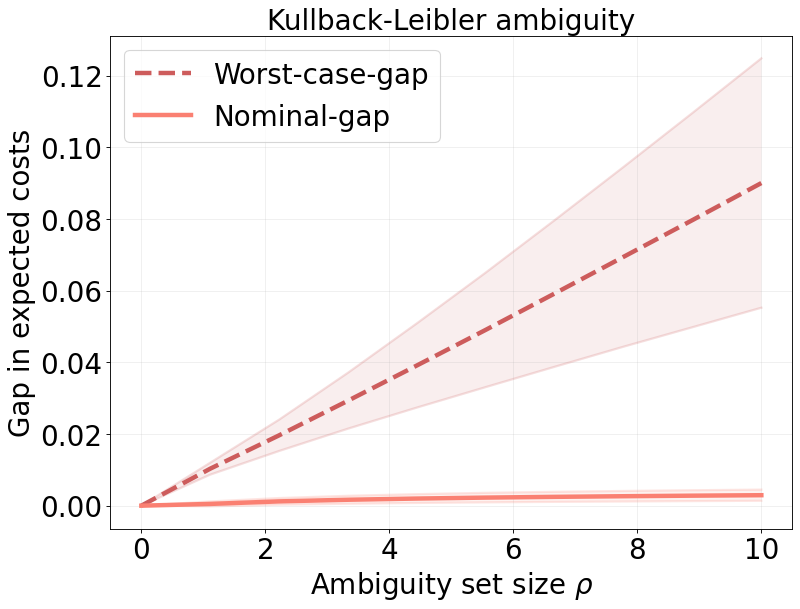

In [10]:

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
cm_piyg = plt.cm.PiYG
cm_bright = ListedColormap(["#b30065", "#178000"])
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
def plot_figure(plt, x, y, color="b", label=None, ls="solid", with_shade=True):
    try:
        mean_ = np.mean(y, axis=1)
        err_ = np.std(y, axis=1) 
        plt.plot(x, mean_, color=color, linewidth=4, linestyle=ls, label=label)
        plt.plot(x, mean_ + err_, color=color, linewidth=2, alpha=0.2)
        plt.plot(x, mean_ - err_, color=color, linewidth=2, alpha=0.2)
        if with_shade:
            plt.fill_between(x, mean_ - err_, mean_ + err_, alpha=0.1, facecolor=color)
    except:
        plt.plot(x, y, color=color, linewidth=3, linestyle=ls, label=label)


fig, ax = plt.subplots(figsize=(11, 8), dpi=80)
plot_figure(ax, rhos, 
            (obj_val_nominal_policy_nominal_worst_dist - obj_val_worst_case_policy_worst_case_dist),
            color=colors["indianred"],
            ls="dashed",
            label="Worst-case-gap")

plot_figure(ax, rhos, 
            (obj_val_worst_case_policy_nominal_dist - obj_val_nominal_policy_nominal_dist),
            color=colors["salmon"],
            label="Nominal-gap")

params = {
    "text.usetex": True,
    "font.size": 18,
    "font.family": "Sharif",
    "text.latex.unicode": True,
}
plt.rcParams.update({'font.size': 25})

plt.grid(True, which="both", alpha=0.2)
plt.ylabel("Gap in expected costs", fontsize=25)
plt.xlabel(r"Ambiguity set size $\rho$", fontsize=25)
if amb_set == "OT":
    plt.title("Wasserstein ambiguity", fontsize=25)
else: 
    plt.title("Kullback-Leibler ambiguity", fontsize=25)


plt.legend(loc="upper left", fontsize=25)
plt.show()

fig.savefig(
            "results/figure-2-{}.pdf".format(amb_set),
            format="pdf",
    )
